In [ ]:
#default_exp learner.learner

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from lib.data.lists import *
import torch.nn.functional as F
import time, math

# Learner

> The the messaging structure used to organise and monitor training of an NN model

In [ ]:
# export

class Event():
    def __init__(self,learner):
        self.learn = learner
        

from enum import Enum,auto
class Stages(Enum):
    begin_fit = auto()
    begin_epoch = auto()
    begin_batch = auto()
    begin_preprocessing = auto(),
    after_preprocessing = auto(),
    begin_prediction = auto()
    after_prediction = auto()
    begin_loss = auto()
    after_loss = auto()
    begin_backwards = auto()
    after_backwards = auto()
    begin_step = auto()
    after_step = auto()
    after_batch = auto()
    after_epoch = auto()
    after_fit = auto()
    begin_validate = auto()
    after_validate = auto()  
    begin_train = auto()
    after_train = auto()  
    
train_batch_stages = [Stages.begin_preprocessing, Stages.after_preprocessing, 
                      Stages.begin_prediction, Stages.after_prediction,
                      Stages.begin_loss,       Stages.after_loss,
                      Stages.begin_backwards,  Stages.after_backwards,
                      Stages.begin_step,       Stages.after_step ]
valid_batch_stages = [Stages.begin_preprocessing, Stages.after_preprocessing,
                      Stages.begin_prediction, Stages.after_prediction,
                      Stages.begin_loss,       Stages.after_loss ]

class Messenger():
    subscriptions = None    
    def __init__(self): self.subscriptions = []
        
    # cbs is instances of Callback whereas cb_funcs are functions that initializes a Callback 
    def register( self, cb:Callback ): self.subscriptions.append(cb)
        
    def register_callback_functions( self, cb_funcs ):
        for cbf in cb_funcs: self.register(cbf())
        
    def notify(self, msg:Stages, event):
        for cb in self.subscriptions: 
            f = getattr(cb, msg.name, None)
            if f is not None and not event.learn.stop: 
                #print(f"in_train: {event.learn.in_train } callback: {type(cb).__name__}.{msg.name}")            
                f(event)
            if event.learn.stop:break
                
#are we missing a begin_train that match begin_validate??????
class Learner():
    #public
    model    = None
    opt      = None
    xb       = None
    yb       = None
    in_train = False
    #epoch    = 0
    epochs   = 0
    loss     = -1
    #private
    _data    = None
    _stop    = None
    
    def __init__(self, model, data, loss_func):
        self.model,self._data,self.loss_func = model,data,loss_func
        #for cb in listify(cbs): self.msn.register(cb)
        self._stop = False
        self.logger = print

    def find_subcription_by_cls(self,cls):
        for s in self.msn.subscriptions:
            if type(s) == cls:return s
        
    @property
    def stop(self): return self._stop
    @stop.setter 
    def stop(self, value): 
        if not self._stop : self._stop = value 

    def fit(self, epochs, opt, cb_funcs):
        self.epochs, self.loss = epochs, tensor(0.)

        self.msn = Messenger()
        self.msn.register_callback_functions(cb_funcs)
        self.opt = opt

        event = Event(self)
        try:
            self.msn.notify(Stages.begin_fit, event)
            for epoch in range(epochs):
                if self.stop: break
                    
                self.epoch = epoch  #due to progressbar
                self.msn.notify(Stages.begin_epoch,event)
                
                self.in_train = True
                self.all_batches(self._data.train_dl, train_batch_stages, 
                                 Stages.begin_train, Stages.after_train)
                self.in_train = False
                
                with torch.no_grad():
                    self.all_batches(self._data.valid_dl, valid_batch_stages, 
                                     Stages.begin_validate, Stages.after_validate)
                        
                self.msn.notify(Stages.after_epoch,event)
        except Exception as e: self.exception_handler(e)
        finally: self.msn.notify(Stages.after_fit, event)

        self.epoch, self.in_train = 0, False
                    
    def all_batches(self, dl, batch_stages, begin_msg:Stages, after_msg:Stages):
        event = Event(self)        
        self.dl    = self._data.train_dl #due to progress bar
        self.iters = len(dl)

        try:
            self.msn.notify(begin_msg,event)
            #for i,(xb,yb,index) in enumerate(dl): 
            for i,(xb,yb) in enumerate(dl): 
                if self.stop: break
                self.iter = i
                self.one_batch(batch_stages, xb, yb)
        except Exception as e: self.exception_handler(e)
        finally: self.msn.notify(after_msg,event)
        self.dl = None
             
    def one_batch(self, batch_stages, xb, yb):
        event = Event(self)        
        self.xb,self.yb = xb,yb
        try:
            self.msn.notify(Stages.begin_batch,event)
            for msg in batch_stages: 
                self.msn.notify(msg,event)
        except Exception as e: self.exception_handler(e)
        finally: self.msn.notify(Stages.after_batch,event)
        self.xb,self.yb = None,None

    def exception_handler(self, e:Exception ):
        self.stop = True
        import traceback
        print("exception: {e}")
        tb = traceback.format_exc()            
        print(f"exception received 3\n:{tb}")
 

# Callbacks

In [ ]:
# export

from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time
import matplotlib.pyplot as plt


#generalize this callback to debug callback
class GetOneBatchCallback(Callback):
    def after_preprocessing(self, e:Event): 
        self.xb,self.yb = e.learn.xb,e.learn.yb
        e.learn.stop = True

class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    def begin_fit(  self, e:Event): e.learn.model.to(self.device)
    def begin_batch(self, e:Event): e.learn.xb, e.learn.yb = e.learn.xb.to(self.device),e.learn.yb.to(self.device)

class SimpleCudaCallback(Callback):
    def __init__(self, device): super()(device = torch.device('cuda',0))
    
        
class BatchTransformXCallback(Callback):
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self, e:Event): e.learn.xb = self.tfm(e.learn.xb)

        
#must always be used for training        
class TrainableModelCallback(Callback):
    def begin_prediction(self,e:Event): e.learn.preds = e.learn.model(e.learn.xb)

    def begin_backwards(self,e:Event): 
        if e.learn.in_train: e.learn.loss.backward()
    
    def begin_loss(self,e:Event): 
        e.learn.loss = e.learn.loss_func(e.learn.preds, e.learn.yb)

#must always be used for training        
class TrainEvalCallback(Callback):
    def begin_train(self,e:Event): 
        if e.learn.in_train: e.learn.model.train()

    def begin_validate(self, e:Event): e.learn.model.eval()
      
 
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = metrics,in_train

    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, learn):
        bn = learn.xb.shape[0]
        self.tot_loss += learn.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(learn.preds, learn.yb) * bn

"""
#class DebugCallback(Callback):
#    def __init__(self, cb_name, f_cond=None): self.cb_name,self.f_cond = cb_name,f_cond
#    def __call__(self, cb_name):
#        if cb_name==self.cb_name:
#            if self.f_cond: self.f_cond(self.run)
#            else:      set_trace()
"""

###################################### Hooks ###################################### 
from functools import partial
class Hook():
    def __init__(self, layer, func): 
        self.layer, self.hook = layer, layer.register_forward_hook(partial(func, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()


class Hooks(ListContainer):
    def __init__(self, modules, f): 
        super().__init__([Hook(m, f) for m in modules])
            
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

class HookCallback(Callback):   
    def __init__(self, hookProcessor): self.hookProcessor = hookProcessor

    def begin_fit(self, e:Event):
        self.lrs = [[] for _ in e.learn.opt.param_groups]
        self.losses = []

    def after_batch(self, e:Event):
        if e.learn.in_train:         
            for pg,lr in zip(e.learn.opt.param_groups, self.lrs): lr.append(pg['lr'])
            self.losses.append(e.learn.loss.detach().cpu())

            
def plot_layer_stats( hooks:Hooks, pct_lower_bins = 2 ):
    def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

    rows = int( len(hooks)/2 + 0.5)
    fig,axes = plt.subplots(rows,2, figsize=(15,3*rows))
    for i,ax,h in zip(range(len(hooks)),axes.flatten(), hooks):
        ax.imshow(get_hist(h), origin='lower', aspect="auto", interpolation="bicubic")
        ax.set(xlabel='iterations', ylabel="histogram", title=f"l:{i}, {type(h.layer)}: ln(output + 1)")  
        #ax.set_axis_off()
        ax.get_yaxis().set_visible(False)
        plt.axis('off')
    plt.tight_layout()
    

    """
    fig,axes = plt.subplots(rows,2, figsize=(15,3*rows))
    sds = np.fromiter( h.stats[2] for h in hooks, dtype=np.float32, count=len(hooks))
    sds_mean = np.mean(sds)

    for i,ax,h in zip(range(len(hooks)),axes.flatten(), hooks):
        ax.plot( get_min2(h, 0.1 * sds_mean) )
        #ax.plot( get_min(h,pct_lower_bins) )
        ax.set_ylim(0,100)
        ax.set(xlabel='iterations', ylabel="% near zero",  title=f"layer {i}, {type(h.layer)}: output near zero")  
    plt.tight_layout()    
    """

    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(15,6))
    for h in hooks:
        ms,ss = h.stats[:2]
        ax0.plot(ms)
        ax0.set(xlabel='iterations', ylabel="mean activation",  title=f"mean of activations pr layers")  
        ax0.legend(range(len(hooks)));
        ax1.plot(ss)
        ax1.set(xlabel='iterations', ylabel="std activation",  title=f"std of activations pr layers")  
        ax1.legend(range(len(hooks)));
    plt.tight_layout()     


def append_stats(hook, module, inp, outp, max_activation=5):
    if module.training:
        if not hasattr(hook,'stats'): hook.stats = ([],[],[])
        means,stds,hists = hook.stats
        means.append(outp.data.mean().cpu())
        stds .append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(100,-max_activation,max_activation)) #histc isn't implemented on the GPU


class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics,True), AvgStats(metrics,False)
        self.first=True

    def begin_epoch(self, e:Event):        
        self.train_stats.reset()
        self.valid_stats.reset()
        self.start_time = time.time()
        if self.first:
            met_names = ['loss'] + [m.__name__ for m in self.train_stats.metrics]
            names = ['epoch'] + [f'train_{n}' for n in met_names] + [
                    f'valid_{n}' for n in met_names] + ['time']
            e.learn.logger(names)
            self.first = False

    def after_loss(self, e:Event):
        stats = self.train_stats if e.learn.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(e.learn)

    def after_epoch(self, e:Event):
        #print(self.train_stats)
        #print(self.valid_stats)
        stats = [str(e.learn.epoch)] 
        for o in [self.train_stats, self.valid_stats]:
            stats += [f'{v:.6f}' for v in o.avg_stats] 
        stats += [format_time(time.time() - self.start_time)]
        e.learn.logger(stats)
        
from IPython.display import display, Javascript
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time
import matplotlib.pyplot as plt
class ProgressCallback(Callback):
    def begin_fit(self,e:Event):
        self.mbar = master_bar(range(e.learn.epochs))
        #self.mbar.on_iter_begin()
        e.learn.logger = partial(self.mbar.write, table=True)
        
    def after_fit(self,e:Event): self.mbar.on_iter_end()
    def after_batch(self,e:Event): self.pb.update(e.learn.iter)
    def begin_train   (self,e:Event): self.set_pb(e.learn)
    def begin_validate(self,e:Event): self.set_pb(e.learn)
    def set_pb(self,learn:Learner):
        self.pb = progress_bar(learn.dl, parent=self.mbar)
        self.mbar.update(learn.epoch)   
        #plot_loss_update(learn.epoch, e.learn.epochs,   )
     
    """
    def plot_loss_update(epoch, epochs, mb, train_loss, valid_loss):
        # dynamically print the loss plot during the training/validation loop.
        # expects epoch to start from 1.
        x = range(1, epoch+1)
        y = np.concatenate((train_loss, valid_loss))
        graphs = [[x,train_loss], [x,valid_loss]]
        x_margin = 0.2
        y_margin = 0.05
        x_bounds = [1-x_margin, epochs+x_margin]
        y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

        mb.update_graph(graphs, x_bounds, y_bounds)
    """
        
class Recorder(Callback):
    def __init__(self):
        self.lrs, self.train_losses, self.valid_losses = None, None, None
        self.optimizers = None
        self.epochs = 0
        
    def begin_fit(self, e:Event):
        self.lrs,self.train_losses, self.valid_losses = [],[],[]
        self.optimizers = None
        self.epochs = e.learn.epochs        
        
    def begin_epoch(self, e:Event):        
        self.valid_losses.append(0)
        self.valid_iterations = 0
            
    def after_batch(self, e:Event):
        if e.learn.in_train:         
            if self.optimizers is None : 
                self.optimizers = { k:[v] for k,v in e.learn.opt.getOptimizers().items() }
            else:                        
                for k,v in e.learn.opt.getOptimizers().items(): self.optimizers[k].append(v)            
            self.train_losses.append(e.learn.loss.detach().cpu())
        else:
            self.valid_losses[e.learn.epoch] += e.learn.loss.detach().cpu() * e.learn.xb.shape[0]
            self.valid_iterations            += e.learn.xb.shape[0]
            
    def after_epoch(self, e:Event):  
        if self.valid_iterations > 0:
            self.valid_losses[e.learn.epoch] /= self.valid_iterations
            
    def plot_lr(self):
        fig, ax = plt.subplots()
        for k,v in self.optimizers.items(): ax.plot(v,label=k)
        ax.legend(loc='upper left')
        ax.set(xlabel='iteration', ylabel='optimizer', title='optimizers')  
            
    def plot_loss(self, skip_start=0, skip_end=0 ): 
        #resample validation losses so the slicin works
        if self.train_losses is None or len(self.train_losses)==0:
            print("no losses to plot")
            return
        else:
            #print(f"self.train_losses:{self.train_losses}")
            fig, ax = plt.subplots()
            s           = slice(skip_start,-skip_end) if skip_end>0 else slice(skip_start, None)
            ticksize    = int(len(self.train_losses)/self.epochs)
            tick_labels = [i for i in range(1,self.epochs+1)]
            tick_pos    = [i*ticksize for i in tick_labels]
            l1 = ax.plot(list(range(len(self.train_losses)))[s],self.train_losses[s],label="training")
            l2 = ax.plot(tick_pos[s],self.valid_losses[s],label="validation")
            plt.xticks(tick_pos[s],tick_labels[s])    
            ax.set(xlabel='epochs', ylabel="losses")  
            ax.legend()
        


# Tests

In [ ]:
from lib.image.image import *
from lib.data.external import *

#config  = IMAGENETTE_160_Configuration()        
config   = MNIST_Configuration()
files    = ImageList.from_files( untar_data(config.url) )
inputTfm = Image2TensorImage()
ds       = ImageDataset(config, files, inputTfm )
ds_train, ds_test = ds.split2train_test()
print(len(files)), print(f"len(ds_train):{len(ds_train)}, len(ds_test):{len(ds_test)} ")
dl_train, dl_test = ds_train.dataloader(128,True), ds_test.dataloader(512, False)
databunch = DataBunch(dl_train, dl_test, config.channels_in, config.channels_out)

len(ds), len(ds_train), len(ds_test),len(dl_train), len(dl_test), 
#ds_train[10], 
len(next(iter(ds_train)))

70000
len(ds_train):60000, len(ds_test):10000 


2

In [ ]:
# export

import torch
import torch.nn.functional as F
import torch.tensor as tensor
from functools import *

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner
    
class OptimizerCallback(Callback):
    def begin_fit(self,e:Event):
        #count iteration to adjust the training params to the progress in the training cycle
        self.n_iter  = 0      
        self.params  = [ p for p in e.learn.model.parameters() if p.requires_grad ]
        #self.mov_avg = [ p*0 for p in self.params ]

    def begin_batch(self,e:Event): 
        if e.learn.in_train:
            self.fractional_cycle = min(1.,self.n_iter /(e.learn.iters * e.learn.epochs))
            e.learn.opt.update(self.fractional_cycle)
        
    def begin_step(self, e:Event):
        if e.learn.in_train:
            #for p in self.params: e.learn.opt.optimize(p)
            e.learn.opt.optimize(self.params)
            #self.mom = 0.9    
            #self.mov_avg = self.mov_avg*self.mom + (1-self.mom) *p.grad.data
            #state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
           
    def after_step(self, e:Event):            
        if e.learn.in_train:
            for p in self.params:
                p.grad.detach_()
                p.grad.zero_()
                
    def after_batch(self,e:Event): 
        if e.learn.in_train: self.n_iter += 1


In [ ]:
mnist_view   = view_tfm(1,28,28)
layers_sizes = [8,16,32,32]
loss_func    = F.cross_entropy
#sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#                partial(CudaCallback, device= torch.device('cuda',0)),
#                partial(ParamScheduler, 'lr', sched),
                partial(BatchTransformXCallback, tfm = mnist_view), 
#                partial(MixUp,α=0.4),
#                LR_Finder,
                Recorder, 
                partial(AvgStatsCallback,[accuracy]),
                ProgressCallback
               ]

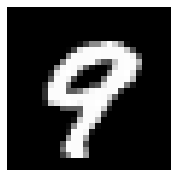

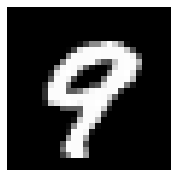

In [ ]:
# test that the tranformations works
from lib.image.image import *
image     = Image.as_tensorimage( files[1] )
affines   = AffineTransforms([Rotation(.3,30), ShiftScale(.3,shift=0.5,scale=0.25)])
image_tfm = affines(image)

gph = Graphics()
gph.show_image(files[1] )
gph.show()
gph.show_image(Image.from_tensorimage(image_tfm))

# Export scripts

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 00_test.ipynb.
Converted 01_data.external.ipynb.
Converted 02_lists.ipynb.
Converted 03_images.ipynb.
Converted 04_databunchs_undone.ipynb.
Converted 05_Learner.ipynb.
Converted 05_model.ipynb.
Converted 06_modelmanger.ipynb.
Converted 07_optimizers.ipynb.
Converted app_image_01_mnist_optimizers.ipynb.
Converted augmentation_cpu.ipynb.
Converted data_block.ipynb.
Converted imagenette_optimizers.ipynb.
Converted index.ipynb.
Converted mnist_experiments.ipynb.
Converted mnist_initi_batchnorm.ipynb.
Converted transfer_learning.ipynb.
